In [ ]:
%%capture
!pip install darts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import darts
import pandas as pd
import numpy as np

from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

from darts import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/beijing_air_data/air_data.csv')
df['timestamp'] = pd.to_datetime(df[["year", "month", "day", "hour"]])

ts_df = df.dropna(subset = ['PM2.5'])

ts_df = ts_df[['PM2.5', 'timestamp', 'station', 'wd', 'WSPM', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'O3', 'CO', 'NO2', 'SO2']]
ts_df = ts_df.dropna(subset=ts_df.columns.values)


d = ts_df['timestamp'] - pd.to_datetime('2013-03-01 00:00:00')

delta_index = []
for delta in d:
    delta_index.append(int(delta.total_seconds()/3600))

ts_df['ts_ind'] = delta_index

target_series = TimeSeries.from_group_dataframe(ts_df[["PM2.5", 'ts_ind', 'station']], group_cols=['station'], time_col='ts_ind')
cov_series = TimeSeries.from_group_dataframe(ts_df.drop(["PM2.5",'timestamp'], axis=1), group_cols=['station'], time_col='ts_ind')

past_point = int(len(cov_series[0]) * 0.8)
future_point = int(len(cov_series[0]) * 0.9)

past_target_series = []
future_target_series = []
test_target_series = []

for ts in target_series:
    past_target_series.append(ts.slice(0, past_point))
    future_target_series.append(ts.slice(past_point, future_point))
    test_target_series.append(ts.slice(future_point, len(ts)))

past_cov_series = []
future_cov_series = []
test_cov_series = []

for ts in cov_series:
    past_cov_series.append(ts.slice(0, past_point))
    future_cov_series.append(ts.slice(0, future_point))
    test_cov_series.append(ts.slice(future_point, len(ts)))

non_static_cov = []

#TCN doesn't use static covariates so we just have the station ID as covars in the time series
for i in range(0, len(cov_series)):
    temp_series = TimeSeries.from_series(pd.DataFrame({'station':[i] * len(cov_series[i])}))
    non_static_cov.append(darts.concatenate([cov_series[i], temp_series], axis=1))

In [ ]:
from darts.models import TFTModel
from darts.models import DLinearModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import NHiTSModel

nhits_model = NHiTSModel.load("/content/drive/MyDrive/nhits_model/12_20")
nbeats_model = NBEATSModel.load('/content/drive/MyDrive/nbeats_model/11_16')
dlin_model = DLinearModel.load('/content/drive/MyDrive/dlinear_model/12_11')
tftmodel = TFTModel.load("/content/drive/MyDrive/tft_model/11_11")
tcn_model = TCNModel.load("/content/drive/MyDrive/tcn_model/12_20")

from darts.models import NaiveDrift

nd_model = NaiveDrift()
nd_model.fit(past_target_series[0])

from darts.metrics.metrics import rmse, mape

In [ ]:
%%capture
tft_backtest_output = tftmodel.backtest(series = test_target_series,
                                      past_covariates=cov_series,
                                      future_covariates=test_cov_series,
                                      retrain=False,
                                      metric=rmse,
                                      start=0.9,
                                      num_samples=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


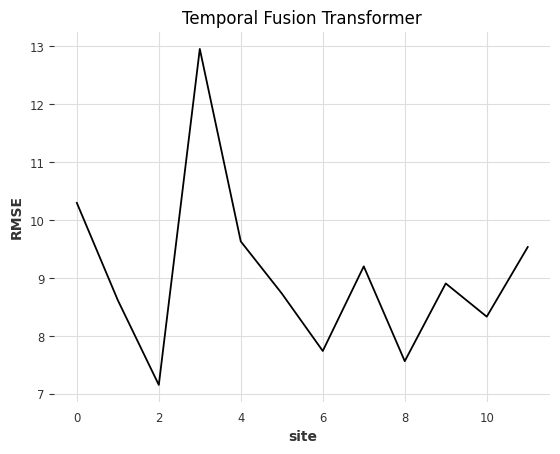

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tft_backtest_output)

ax.set(xlabel='site', ylabel='RMSE')
plt.title("Temporal Fusion Transformer")
plt.show()

In [ ]:
tcn_backtest = tcn_model.backtest(series = test_target_series,
                                  past_covariates=non_static_cov,
                                  retrain=False,
                                  metric=rmse,
                                  start=0.9,
                                  num_samples=200)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


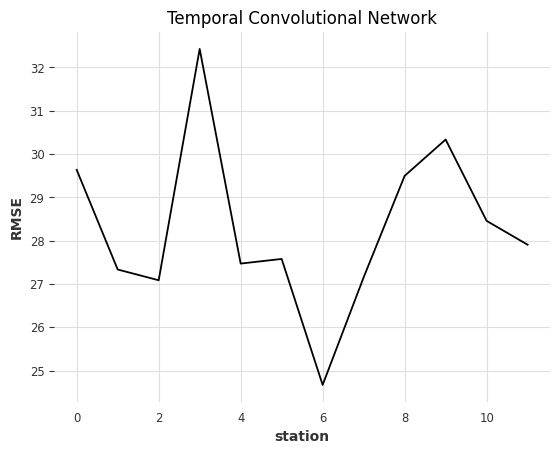

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tcn_backtest)

ax.set(xlabel='station', ylabel='RMSE')
plt.title("Temporal Convolutional Network")
plt.show()

In [ ]:
nbeats_backtest = nbeats_model.backtest(series = test_target_series,
                                  past_covariates=cov_series,
                                  retrain=False,
                                  metric=rmse,
                                  start=0.9)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


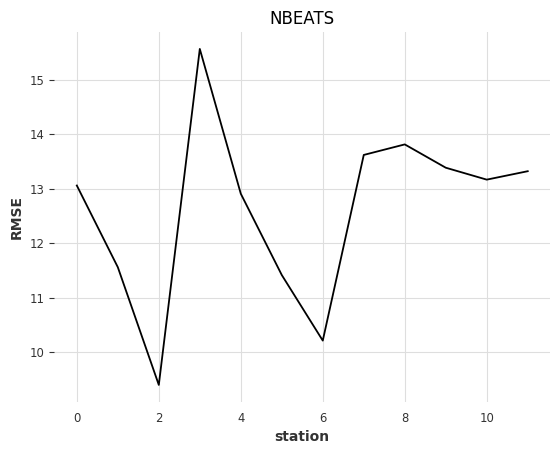

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nbeats_backtest)

ax.set(xlabel='station', ylabel='RMSE')
plt.title("NBEATS")
plt.show()

In [ ]:
from darts.metrics.metrics import rmse, mape

naive_backtest = nd_model.backtest(test_target_series, start=0.9, metric=rmse)

In [ ]:
dlin_backtest = dlin_model.backtest(series = test_target_series,
                               past_covariates=cov_series,
                               future_covariates=test_cov_series,
                               retrain=False,
                               metric=rmse,
                               start=0.9)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


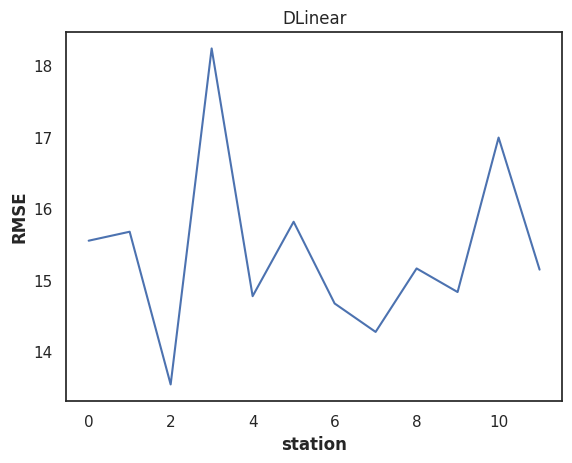

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(dlin_backtest)

ax.set(xlabel='station', ylabel='RMSE')
plt.title("DLinear")
plt.show()

In [ ]:
nhits_backtest = nhits_model.backtest(series=test_target_series,
                    past_covariates=cov_series,
                    retrain=False,
                    metric=rmse,
                    start=0.9,
                    num_samples=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


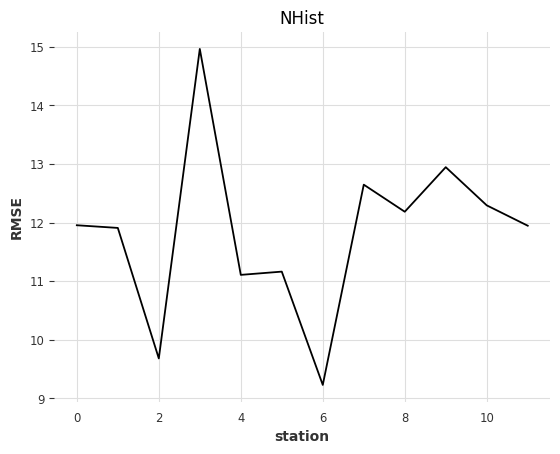

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nhits_backtest)

ax.set(xlabel='station', ylabel='RMSE')
plt.title("NHist")
plt.show()

In [ ]:
import numpy as np
from itertools import repeat

model_list = ['TFT','TCN','NBEATS', 'NHiTS', 'DLinear','Naive Drift']

results_df = pd.DataFrame(columns=['model','site','rmse'])
results_df['model'] = np.repeat(model_list,len(dlin_backtest))
results_df['site'] = list(range(0,len(dlin_backtest))) * len(model_list)
results_df['rmse'] = np.concatenate((tft_backtest_output,tcn_backtest,nbeats_backtest,nhits_backtest,dlin_backtest,naive_backtest))

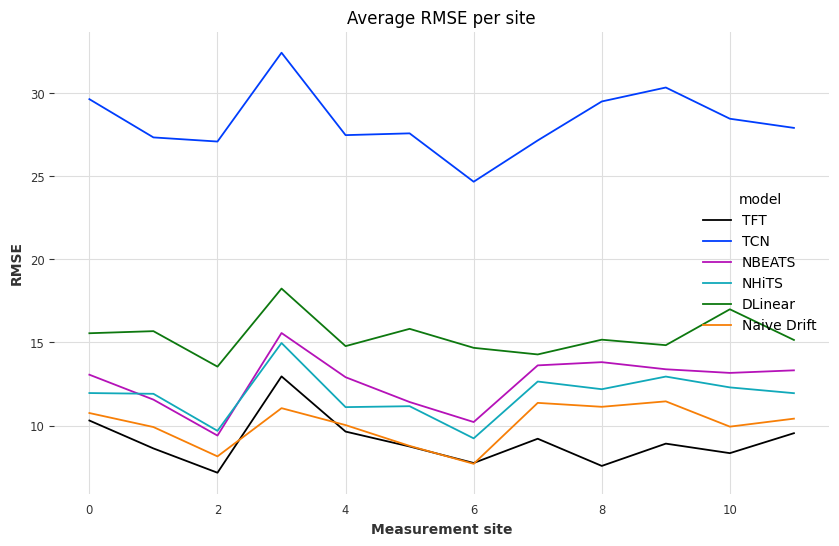

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(10, 6))
sns.lineplot(x='site', y='rmse', data=results_df, hue='model').set(title='Average RMSE per site', xlabel='Measurement site', ylabel='RMSE')
sns.set_theme(style='white', font_scale=1)

In [ ]:
start_location = 0.5

naive_backtest_series = nd_model.backtest(test_target_series,
                                          start=start_location,
                                          metric=rmse,
                                          reduction=None)

tft_backtest_series = tftmodel.backtest(series = test_target_series,
                                        past_covariates=cov_series,
                                        future_covariates=test_cov_series,
                                        retrain=False,
                                        metric=rmse,
                                        start=start_location,
                                        num_samples=100,
                                        reduction=None)

nhits_backtest_series = nhits_model.backtest(series=test_target_series,
                                            past_covariates=cov_series,
                                            retrain=False,
                                            metric=rmse,
                                            start=start_location,
                                            num_samples=100,
                                            reduction=None)

dlin_backtest_series = dlin_model.backtest(series = test_target_series,
                                          past_covariates=cov_series,
                                          future_covariates=test_cov_series,
                                          retrain=False,
                                          metric=rmse,
                                          start=start_location,
                                          reduction=None)

nbeats_backtest_series = nbeats_model.backtest(series = test_target_series,
                                              past_covariates=cov_series,
                                              retrain=False,
                                              metric=rmse,
                                              start=start_location,
                                              reduction=None)

dlin_backtest_series = dlin_model.backtest(series = test_target_series,
                                          past_covariates=cov_series,
                                          future_covariates=test_cov_series,
                                          retrain=False,
                                          metric=rmse,
                                          start=start_location,
                                          reduction=None)

tcn_backtest_series = tcn_model.backtest(series = test_target_series,
                                        past_covariates=non_static_cov,
                                        retrain=False,
                                        metric=rmse,
                                        start=start_location,
                                        num_samples=100,
                                        reduction=None)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HP

In [ ]:
tft_backtest_df = pd.DataFrame(np.row_stack(tft_backtest_series))
tft_backtest_df.to_csv("/content/drive/MyDrive/backtests/tft_backtest.csv")

tcn_backtest_df = pd.DataFrame(np.row_stack(tcn_backtest_series))
tcn_backtest_df.to_csv("/content/drive/MyDrive/backtests/tcn_backtest.csv")

nbeats_backtest_df = pd.DataFrame(np.row_stack(nbeats_backtest_series))
nbeats_backtest_df.to_csv("/content/drive/MyDrive/backtests/nbeats_backtest.csv")

nhits_backtest_df = pd.DataFrame(np.row_stack(nhits_backtest_series))
nhits_backtest_df.to_csv("/content/drive/MyDrive/backtests/nhits_backtest.csv")

dlin_backtest_df = pd.DataFrame(np.row_stack(dlin_backtest_series))
dlin_backtest_df.to_csv("/content/drive/MyDrive/backtests/dlin_backtest.csv")

naive_backtest_df = pd.DataFrame(np.row_stack(naive_backtest_series))
naive_backtest_df.to_csv("/content/drive/MyDrive/backtests/naive_backtest.csv")

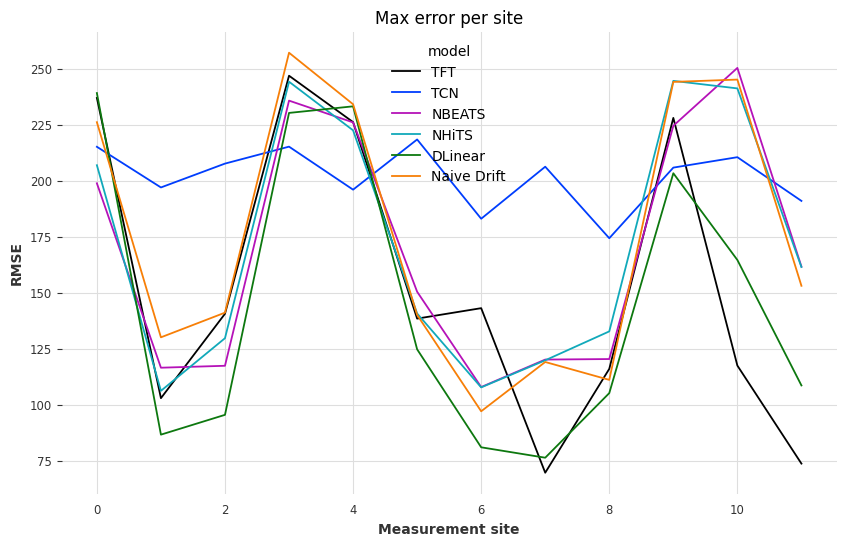

In [ ]:
import numpy as np
from itertools import repeat

model_list = ['TFT','TCN','NBEATS', 'NHiTS', 'DLinear','Naive Drift']

results_df = pd.DataFrame(columns=['model','site','rmse'])
results_df['model'] = np.repeat(model_list,len(dlin_backtest_series))
results_df['site'] = list(range(0,len(dlin_backtest_series))) * len(model_list)
results_df['rmse'] = np.concatenate((tft_backtest_series,tcn_backtest_series,nbeats_backtest_series,nhits_backtest_series,dlin_backtest_series,naive_backtest_series))

fig = plt.subplots(figsize=(10, 6))
sns.lineplot(x='site', y='rmse', data=results_df, hue='model').set(title='Max error per site', xlabel='Measurement site', ylabel='RMSE')
sns.set_theme(style='white', font_scale=1)

In [ ]:
!pip install fastdtw

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

import numpy as np

Text(0.5, 1.0, 'Dynamic Time Warping Distance between errors and target')

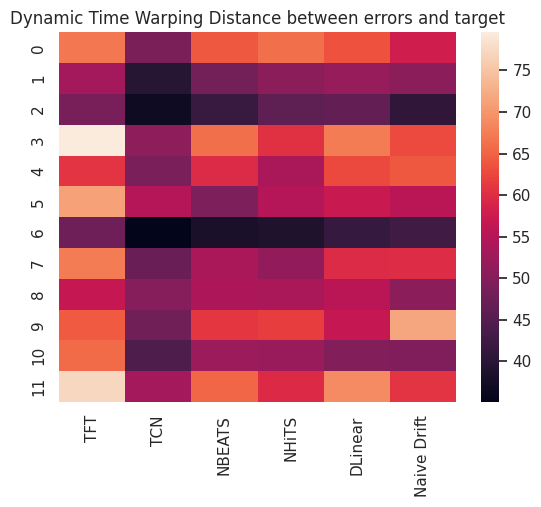

In [ ]:
import itertools

model_list = ['TFT','TCN','NBEATS', 'NHiTS', 'DLinear','Naive Drift']
prediction_list = [tft_backtest_series, tcn_backtest_series, nbeats_backtest_series, nhits_backtest_series, dlin_backtest_series, naive_backtest_series]

results_df = pd.DataFrame(columns=['model','station','dtw_dist'])
results_df['model'] = np.repeat(model_list,len(test_target_series))
results_df['station'] = list(range(0,len(test_target_series))) * len(model_list)

dist_mat = pd.DataFrame()

for (model, predict_series) in zip(model_list, prediction_list):
  dists = []
  for (target, predict) in zip(test_target_series, predict_series):
    target_tail = target['PM2.5'].pd_series().tolist()[-len(predict):]
    dtw_distance, warp_path = fastdtw(target_tail, predict, dist=2)
    dists.append(dtw_distance/len(target_tail))
  dist_mat[model] = dists

sns.set_theme(style='white', font_scale=1)
sns.heatmap(dist_mat)
plt.title("Dynamic Time Warping Distance between errors and target")

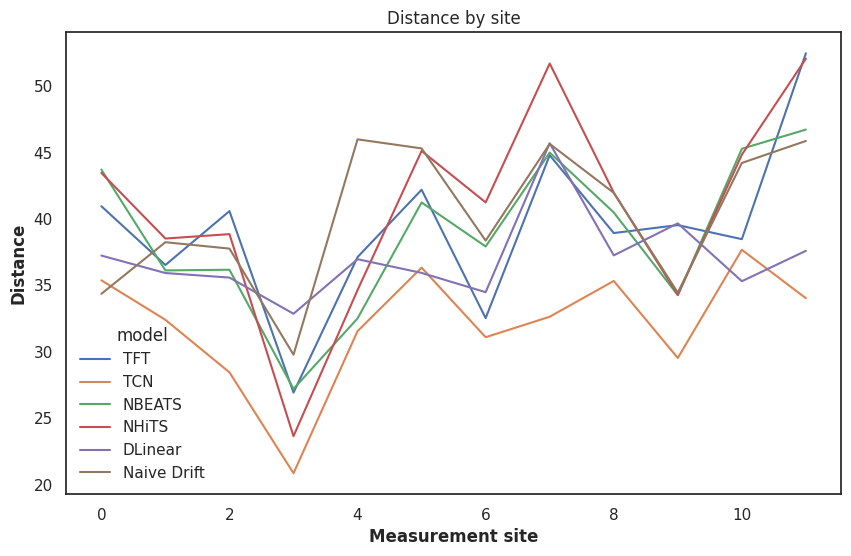

In [ ]:
dtws = dist_mat.stack().reset_index()
dtws.columns = ['station', 'model', 'dtw_dist']

fig = plt.subplots(figsize=(10, 6))
sns.lineplot(x='station', y='dtw_dist', data=dtws, hue='model').set(title='Distance by site', xlabel='Measurement site', ylabel='Distance')
sns.set_theme(style='white', font_scale=1)

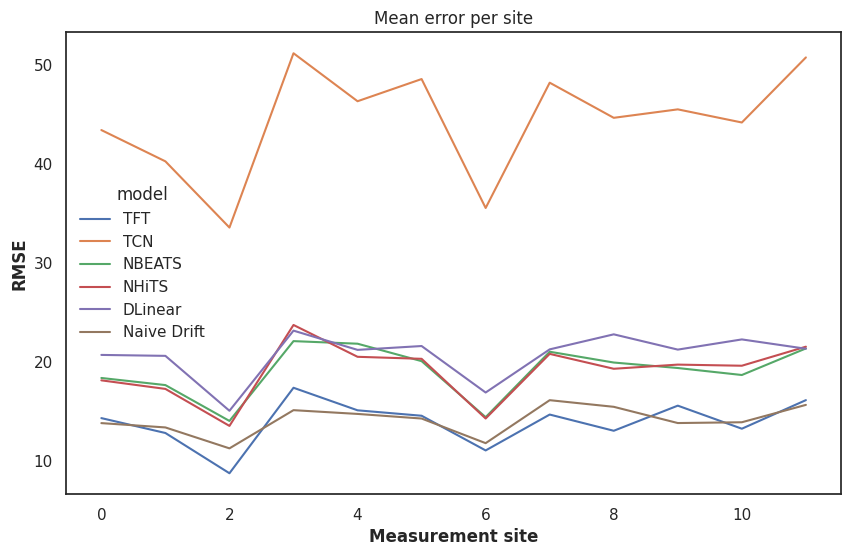

In [ ]:
model_list = ['TFT','TCN','NBEATS', 'NHiTS', 'DLinear','Naive Drift']

def mean_rmse(outputs):
  means = []
  for o in outputs:
    means.append(np.mean(o))
  return means

results_df = pd.DataFrame(columns=['model','site','rmse'])
results_df['model'] = np.repeat(model_list,len(dlin_backtest_series))
results_df['site'] = list(range(0,len(dlin_backtest_series))) * len(model_list)
results_df['rmse'] = np.concatenate((mean_rmse(tft_backtest_series),
                                    mean_rmse(tcn_backtest_series),
                                    mean_rmse(nbeats_backtest_series),
                                    mean_rmse(nhits_backtest_series),
                                    mean_rmse(dlin_backtest_series),
                                    mean_rmse(naive_backtest_series)))

fig = plt.subplots(figsize=(10, 6))
sns.lineplot(x='site', y='rmse', data=results_df, hue='model').set(title='Mean error per site', xlabel='Measurement site', ylabel='RMSE')
sns.set_theme(style='white', font_scale=1)

In [ ]:
np.mean(mean_rmse(tft_backtest_series)) - np.mean(mean_rmse(naive_backtest_series))

-0.2236660970731279

In [ ]:
shortest_series = len(tft_backtest_series[0])

cov_tails = []
target_tails = []

for (target, predict) in zip(test_target_series, tcn_backtest_series):
    target_tails.append( target['PM2.5'].pd_series().tolist()[-len(predict):])

for (cov, predict) in zip(test_cov_series, tcn_backtest_series):
    cov_tails.append( cov[-len(predict):])

ts_compare = pd.DataFrame()
ts_target = pd.DataFrame()

ts_target['Target'] = target_tails[0][:shortest_series]

ts_compare['TCN'] = tcn_backtest_series[0][:shortest_series]
ts_compare['TFT'] = tft_backtest_series[0][:shortest_series]
ts_compare['NBEATS'] = nbeats_backtest_series[0][:shortest_series]
ts_compare['NHITS'] = nhits_backtest_series[0][:shortest_series]
ts_compare['DLIN'] = dlin_backtest_series[0][:shortest_series]
ts_compare['Naive'] = naive_backtest_series[0][:shortest_series]

ts_compare = ts_compare.stack().reset_index()
ts_compare.columns = ['time_index', 'model', 'value']

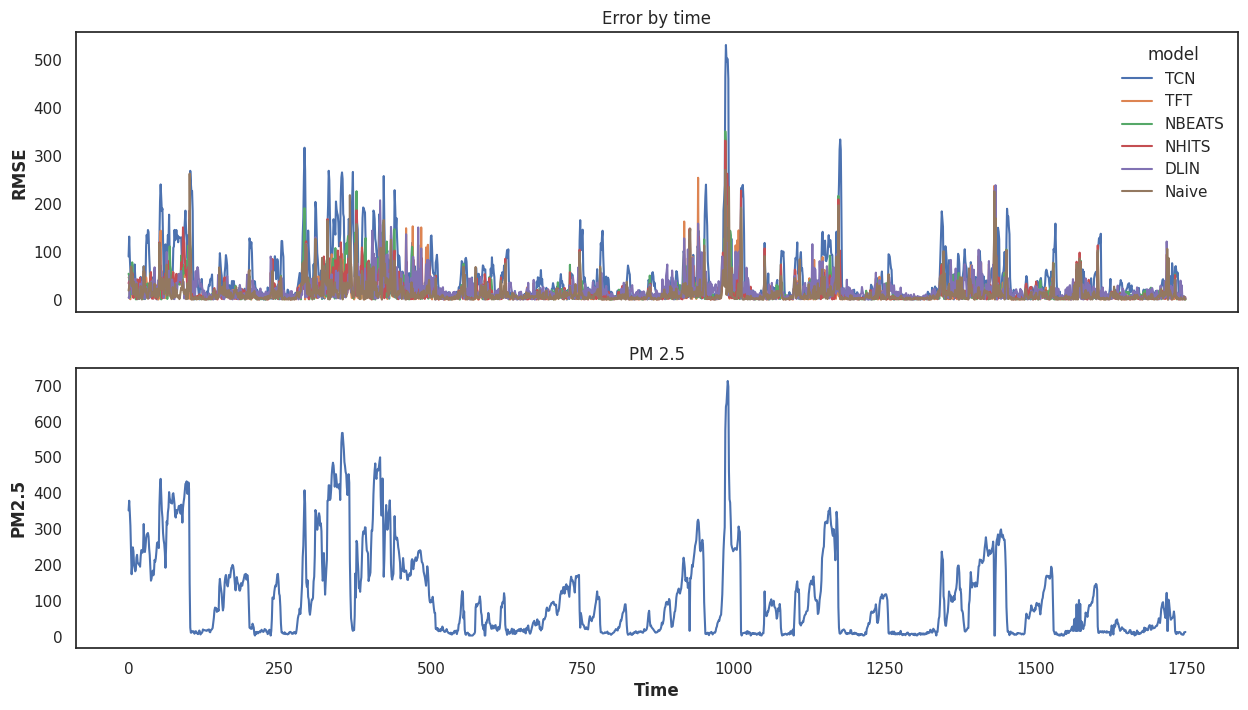

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True)
sns.lineplot(ax=axes[0], x='time_index', y='value', data=ts_compare, hue='model').set(title='Error by time', xlabel='Time', ylabel='RMSE')
sns.lineplot(ax=axes[1], x = 'index', y='Target', data=ts_target.reset_index()).set(title='PM 2.5', xlabel='Time', ylabel='PM2.5')
sns.set_theme(style='white', font_scale=1)
plt.show()

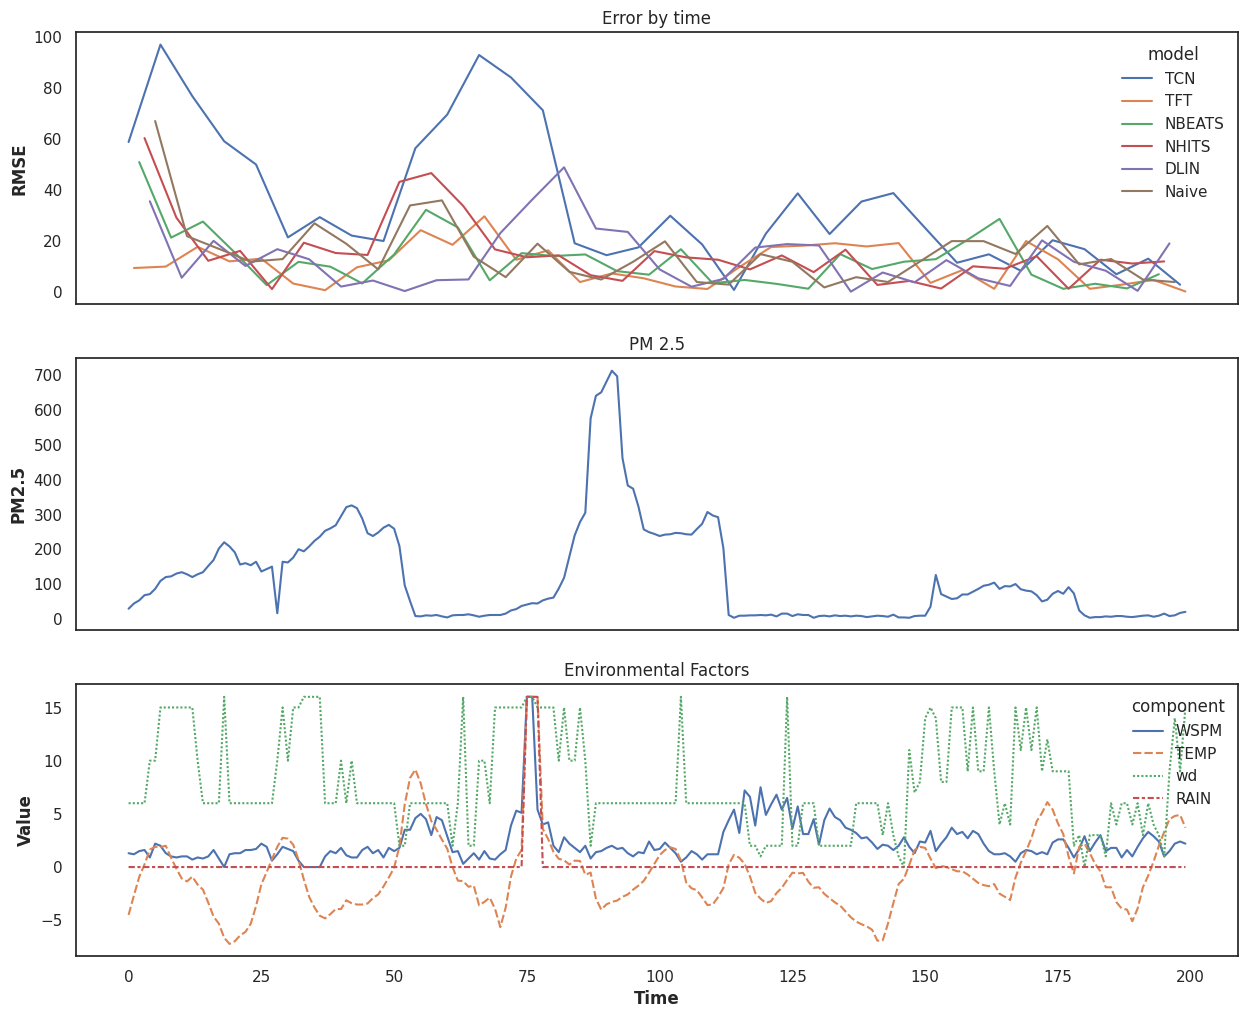

In [ ]:
resized_compare = ts_compare[900:1100].reset_index()
resized_target = ts_target[900:1100].reset_index()

resized_cov = cov_tails[0].pd_dataframe()[900:1100].reset_index()
resized_cov = resized_cov[['WSPM', 'TEMP', 'wd', 'RAIN']]

fig, axes = plt.subplots(3,1, figsize=(15, 12), sharex=True)
sns.lineplot(ax=axes[0], x=resized_compare.index, y='value', data=resized_compare
             , hue='model').set(title='Error by time', xlabel='Time', ylabel='RMSE')
sns.lineplot(ax=axes[1], x = resized_target.index, y='Target', data=resized_target).set(title='PM 2.5', xlabel='Time', ylabel='PM2.5')
sns.lineplot(ax=axes[2], data=resized_cov).set(title='Environmental Factors', xlabel='Time', ylabel='Value')
sns.set_theme(style='white', font_scale=0.5)
plt.show()

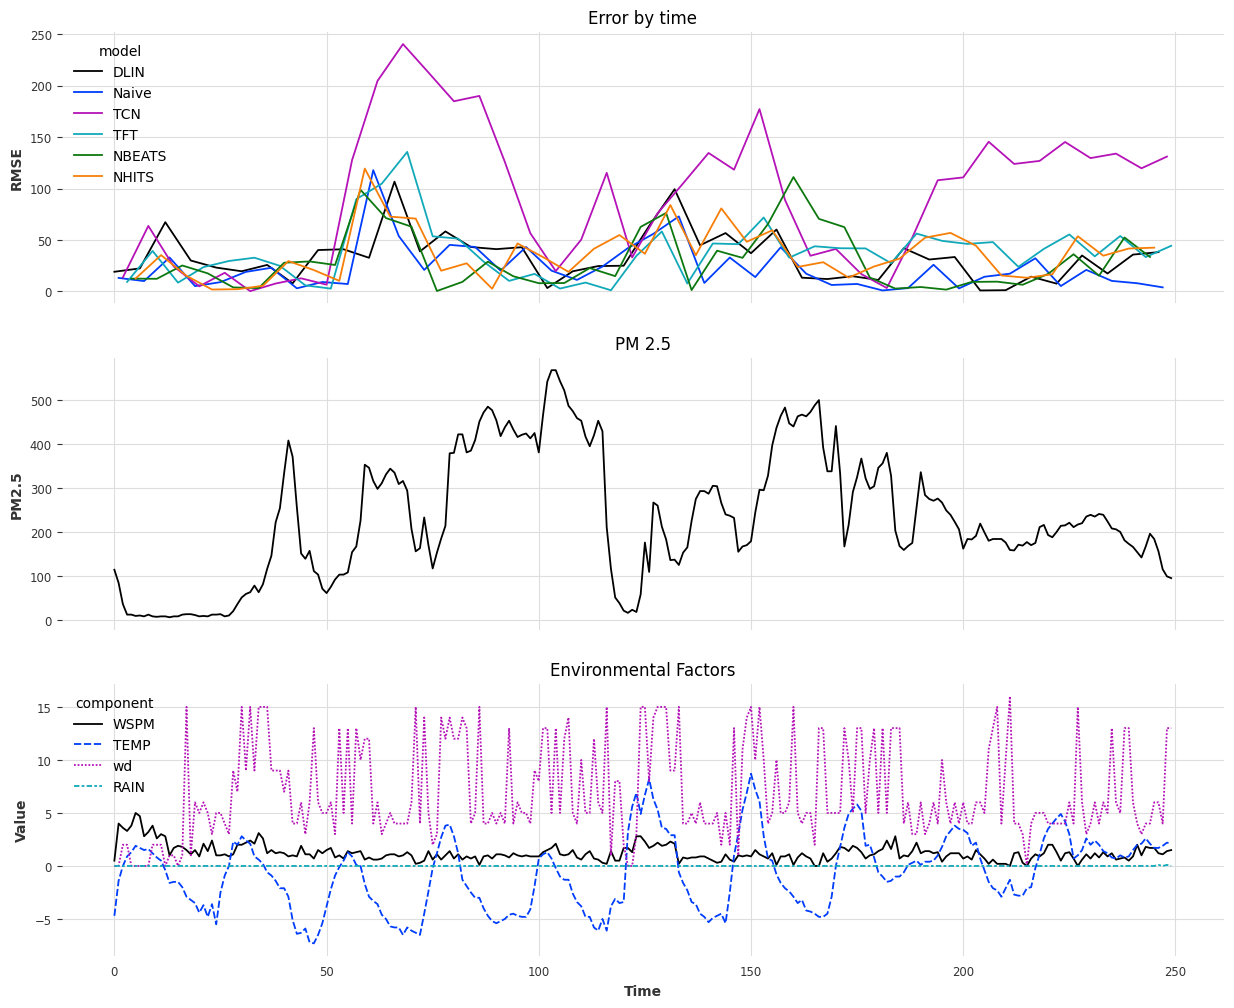

In [ ]:
resized_compare = ts_compare[250:500].reset_index()
resized_target = ts_target[250:500].reset_index()

resized_cov = cov_tails[0].pd_dataframe()[250:500].reset_index()
resized_cov = resized_cov[['WSPM', 'TEMP', 'wd', 'RAIN']]

fig, axes = plt.subplots(3,1, figsize=(15, 12), sharex=True)
sns.lineplot(ax=axes[0], x=resized_compare.index, y='value', data=resized_compare
             , hue='model').set(title='Error by time', xlabel='Time', ylabel='RMSE')
sns.lineplot(ax=axes[1], x = resized_target.index, y='Target', data=resized_target).set(title='PM 2.5', xlabel='Time', ylabel='PM2.5')
sns.lineplot(ax=axes[2], data=resized_cov).set(title='Environmental Factors', xlabel='Time', ylabel='Value')
sns.set_theme(style='white', font_scale=0.5)
plt.show()

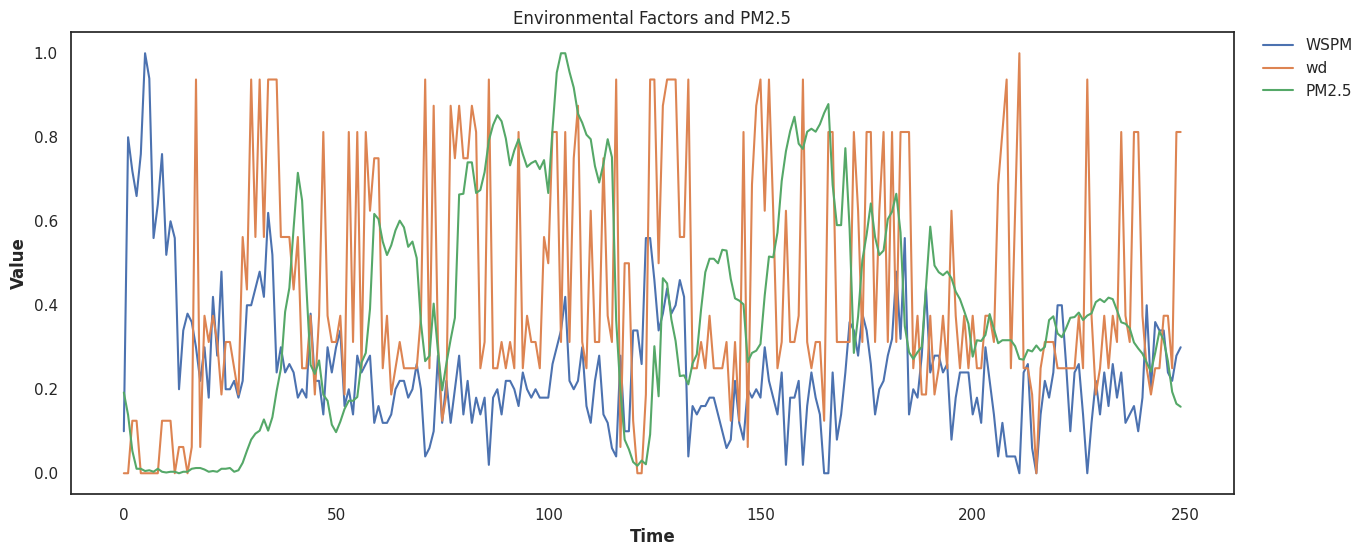

In [ ]:
resized_target = ts_target[250:500].reset_index()

resized_target = ((resized_target-resized_target.min())/(resized_target.max()-resized_target.min()))

resized_cov = cov_tails[0].pd_dataframe()[250:500].reset_index()
resized_cov = resized_cov[['WSPM', 'wd']]
resized_cov["PM2.5"] = resized_target["Target"]

resized_cov = ((resized_cov-resized_cov.min())/(resized_cov.max()-resized_cov.min()))

sns.set_theme(style='white', font_scale=1.0)
fig, axes = plt.subplots(figsize=(15, 6))
#sns.lineplot(x = resized_target.index, y='Target', data=resized_target, color='black').set(title='PM 2.5', xlabel='Time', ylabel='PM2.5')
sns.lineplot(data=resized_cov, dashes=False).set(title='Environmental Factors and PM2.5', xlabel='Time', ylabel='Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
resized_target

,index,Target
0,0.000000,0.192171
1,0.004016,0.138790
2,0.008032,0.053381
3,0.012048,0.010676
4,0.016064,0.010676
...,...,...
245,0.983936,0.316726
246,0.987952,0.266904
247,0.991968,0.193950
248,0.995984,0.165480
